# [Classification 평가] COVID 이미지 분류 신경망 구현

### 지금까지 실습했던 노트북을 통해서 COVID 이미지 분류 신경망을 구현해봅시다.
### 해당 주피터 노트북 파일은 기존의 Classification_Sementation 폴더 내에 다운받아 사용하셔야 합니다.

### 평가 지표는 COVID test 데이터셋에 대한 정확도입니다.
### 평가를 위해 제출하셔야될 파일은 총 세 가지입니다.
1. `#####` 부분을 직접 작성하셔서 완성한 주피터 노트북 파일
2. 해당 주피터 노트북을 실행시켜 얻은 `best_model.pth` 파일
3. 코드 설명 ppt 파일

### 꼭 구현하셔야 할 부분은 크게 세 가지입니다.
1. 신경망이 사용할 **`Block 구조`**를 구현하셔야 합니다. 
2. 신경망 학습에 사용될 `optimizer`와 그에 따른 `argument (ex. learning_rate, momentum, weight_decay)` 등을 설정하셔야 합니다.
3. `#####` 으로 표시된, 실습시간에 배웠던 기본적인 pytorch 학습 문법을 작성하셔야 합니다.

### 성능 향상을 위해 바꿔보신 것들이 있으시면, 자유롭게 하시면 됩니다.
#### [hint] Block 뿐만 아니라, LGNet의 구조에 사용된 값, 모양 또한 변화시켜도 됩니다.
#### [hint] Data를 구성할 때, valid_size, batch_size, augmentation 등을 변화시켜볼 수도 있습니다.

In [1]:
import torch
import os
from materials.stat_image import _get_mean, _get_var

In [2]:
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import matplotlib.pyplot as plt

# Transform 함수

아래는 만들었던 directory에서 파일 정보를 불러와서 `dataset & dataloader`를 만듭니다.

전이(Transform)를 적용한 dataset을 만들기 위해서 만들 것입니다.

Pytorch에서 Dataset의 샘플링은 다음과 같이 됩니다.

- 이미지는 파일 전체를 메모리에 올리지않고 필요할 때마다 불러와서 읽습니다.
- 그 후, 불러온 이미지에 만들어둔 Transform을 적용합니다.
- Transform 중 하나가 랜덤이기 때문에, 데이터는 샘플링 때 증가합니다.

- datasets.ImageFolder: 정해진 폴더 디렉토리의 데이터를 불러옵니다.
- torch.utils.data.Dataloader: 만들어진 dataset을 batch단위로 묶어줍니다.
- SubsetRandomSampler: dataset의 리스트 중엣서 정해진 index의 데이터로 새롭게 재구성합니다. 이는 valid set을 만들기 위함입니다.

In [3]:
def load_split_train_valid(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    valid_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    
    num_train = len(train_data)
    indices = list(range(num_train))
    
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(valid_idx)}
    
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    validloader = torch.utils.data.DataLoader(valid_data,
                   sampler=valid_sampler, batch_size=8)
    
    return trainloader, validloader, dataset_size

In [4]:
path = './COVID19-DATASET/train/'
if os.path.isdir('./COVID19-DATASET/test/.ipynb_checkpoints'):
    os.path.rmdir('./COVID19-DATASET/test/.ipynb_checkpoints')

In [5]:
mean = _get_mean(path)
var = _get_var(path)

## Transforms

우리가 만들고자 하는 신경망은 고정된 크기의 이미지를 입력으로 받게 만듭니다.

여기서 몇가지의 `transforms`함수를 만들어볼 것입니다.

- `Resize`, `RandomRotation`, `RandomHorizontalFlip`, `ToTensor`, `Normalize`입니다. 각각은 아래와 같습니다.
- `Resize`는 이미지의 크기를 고정된 크기로 만들어주기 위함입니다.
- `RandomRotation`은 이미지를 최대 10도를 랜덤으로 돌리는 함수 입니다.
- `RandomHorizontalFlip`은 수평으로 일정한 확률로 뒤집어주는 함수 입니다.
- `ToTensor`는 0과 1 사이의 값을 갖는 tensor로 변환시켜주는 함수입니다.
- `Normalize`는 정해진 mean, var를 통해 데이터를 normalize하는 함수입니다. (픽셀 단위로)

In [6]:
data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), 
                                transforms.RandomRotation(10), 
                                transforms.RandomHorizontalFlip(p=0.4),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean = mean, std=var)]),
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std = var)
                    ])}

In [7]:
trainloader, valloader, dataset_size = load_split_train_valid(path, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
for cls in class_names:
    if cls not in ['covid19', 'normal']:
        class_names.remove(cls)
print(class_names)

['covid19', 'normal']


만들어준 데이터를 다시 시각화하기 위한 함수입니다.

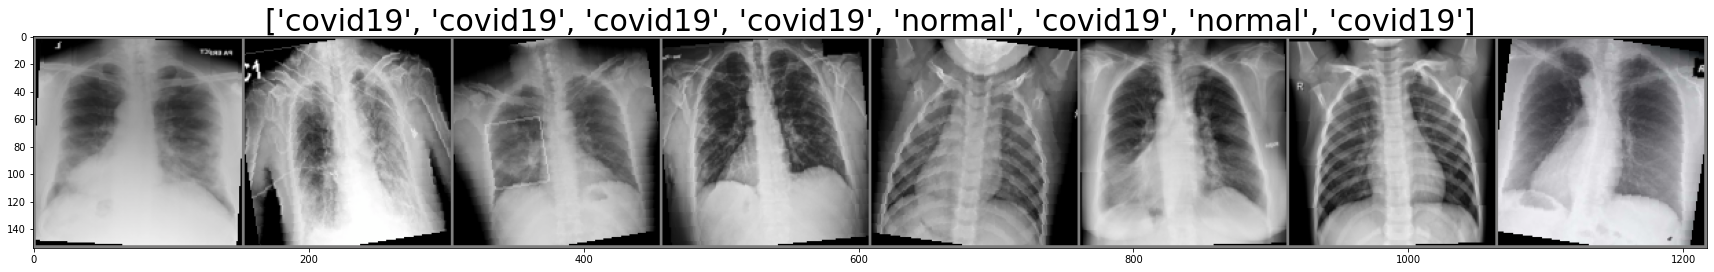

In [8]:
def imshow(inp, mean, std, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean, var, title=[class_names[x] for x in classes])

torch에서 gpu를 통해 학습을 하기 위함입니다.

In [9]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


## 아래 Block 코드를 작성해주세요.

In [10]:
import torch.nn as nn

In [13]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, stride, padding=1):
        super(Block, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=(3,3), padding=padding, stride=stride)
        self.batchnorm = nn.BatchNorm2d(num_features=out_planes)
        self.relu = nn.ReLU()
        
        #############################
        ######### 작성해주세요 #########
        
        
        
        #############################
        

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        out = self.relu(x)
        #############################
        ######### 작성해주세요 #########
        
        
        
        #############################
        
        
        return out

In [14]:
class LGNet(nn.Module):
    def __init__(self):
        super(LGNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #############################
        ######### 작성해주세요 #########
        
        self.layer1 = Block(in_planes=16, out_planes=32, stride=1, padding=1)
        self.layer2 = Block(in_planes=32, out_planes=64, stride=2, padding=1)
        self.layer3 = Block(in_planes=64, out_planes=128, stride=2, padding=1)
        self.layer4 = Block(in_planes=128, out_planes=256, stride=1, padding=1)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 2)
        
        
        #############################

        # initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [15]:
model = LGNet()
model = model.to(device)

In [ ]:
import torch.optim as optim

## 아래 부분을 작성해주세요.

In [ ]:
#############################
######### 작성해주세요 #########

criterion = ??????


optimizer = ??????


#############################


# LR은 exponential decay를 사용.
# step size를 5로 두어 7마다 0.1(gamma)씩 decay하게 만듬
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # Learning Scheduler

In [ ]:
# 전체 parameter의 개수
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

## 최종: 신경망 train 함수 만들기

In [ ]:
import time
import copy
import tqdm

from sklearn.metrics import accuracy_score, cohen_kappa_score

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    results = {'train': {'acc': [], 'loss': []},
               'val': {'acc': [], 'loss': []}}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=True):
                #############################
                ######### 작성해주세요 #########

                # inputs, labels tensor를 gpu device로 올려주세요.
                inputs = ??????
                labels = ??????

                # 학습하기 전, 신경망 Parameter의 grdient를 0으로 초기화해주세요.
                ??????
                

                #############################

                
                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #############################
                        ######### 작성해주세요 #########

                        # 위에서 criterion으로 계산한 loss에 대한 gradient를 계산해주세요.
                        ??????
                        
                        
                        # optimizer를 통해, 위에서 계산한 gradient로 신경망 parameter를 업데이트해주세요.
                        ??????
                        

                        #############################
                
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            
            results[phase]['loss'].append(epoch_loss)
            results[phase]['acc'].append(epoch_acc)
            
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, results

In [ ]:
def visualize_model(model, mean, var, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], mean, var, (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#############################
######### 작성해주세요 #########

# 학습 epoch 수를 지정해주세요.
num_epochs = ??????


#############################

base_model, results = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(results['train']['loss'], color='tab:blue', label='train_loss')
axes[0].plot(results['val']['loss'], color='tab:orange', label='val_loss')
axes[0].set_title('Loss results')
axes[0].legend()

axes[1].plot(results['train']['acc'], color='tab:blue', label='train_acc')
axes[1].plot(results['val']['acc'], color='tab:orange', label='val_acc')
axes[1].set_title('Accuracy results')
axes[1].legend()

plt.show()

In [ ]:
visualize_model(base_model, mean, var)
plt.show()

In [ ]:
torch.save(base_model.state_dict(), './best_model.pth')